# model 4

In [1]:
# Run development environment checks for gpu compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

2025-07-21 10:53:54.426590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753095234.448763    9862 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753095234.456098    9862 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753095234.473761    9862 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753095234.473787    9862 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753095234.473792    9862 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Is built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Run pip dependency fallbacks on env if needed
#!pip install datasets

In [ ]:
#!pip install xgboost

In [ ]:
#!pip install graphviz

In [ ]:
#!pip install seaborn

In [3]:
#!rm -rf ~/.cache/huggingface/datasets

In [9]:
# XGBoost GPU-build
import numpy as np
import xgboost as xgb
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import random

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
USE_PERCENTAGE = 0.10

train_size = int(USE_PERCENTAGE * len(dataset["train"]))
val_size = int(USE_PERCENTAGE * len(dataset["val"]))

train_data = dataset["train"].select(range(train_size))
val_data = dataset["val"].select(range(val_size))


# Binary classification task:
# 1 if image matches LaTeX, 0 if it's a random mismatch
latex_pool = train_data["latex"]

def add_label(example):
    if random.random() > 0.5:
        example["target"] = 1
        example["paired_latex"] = example["latex"]
    else:
        wrong = random.choice(latex_pool)
        while wrong == example["latex"]:
            wrong = random.choice(latex_pool)
        example["target"] = 0
        example["paired_latex"] = wrong
    return example

train_data = train_data.map(add_label)
val_data = val_data.map(add_label)

# Feature engineering
X_train = train_data["paired_latex"]
y_train = np.array(train_data["target"])
X_val = val_data["paired_latex"]
y_val = np.array(val_data["target"])

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric=["logloss", "error"]
)

eval_set = [(X_train_vec, y_train), (X_val_vec, y_val)]
model.fit(
    X_train_vec,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Model evals
y_pred = model.predict(X_val_vec)
acc = accuracy_score(y_val, y_pred)
print(classification_report(y_val, y_pred))

/home/ubuntu/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:12:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.50      0.60      0.54       796
           1       0.47      0.37      0.42       771

    accuracy                           0.49      1567
   macro avg       0.48      0.49      0.48      1567
weighted avg       0.48      0.49      0.48      1567



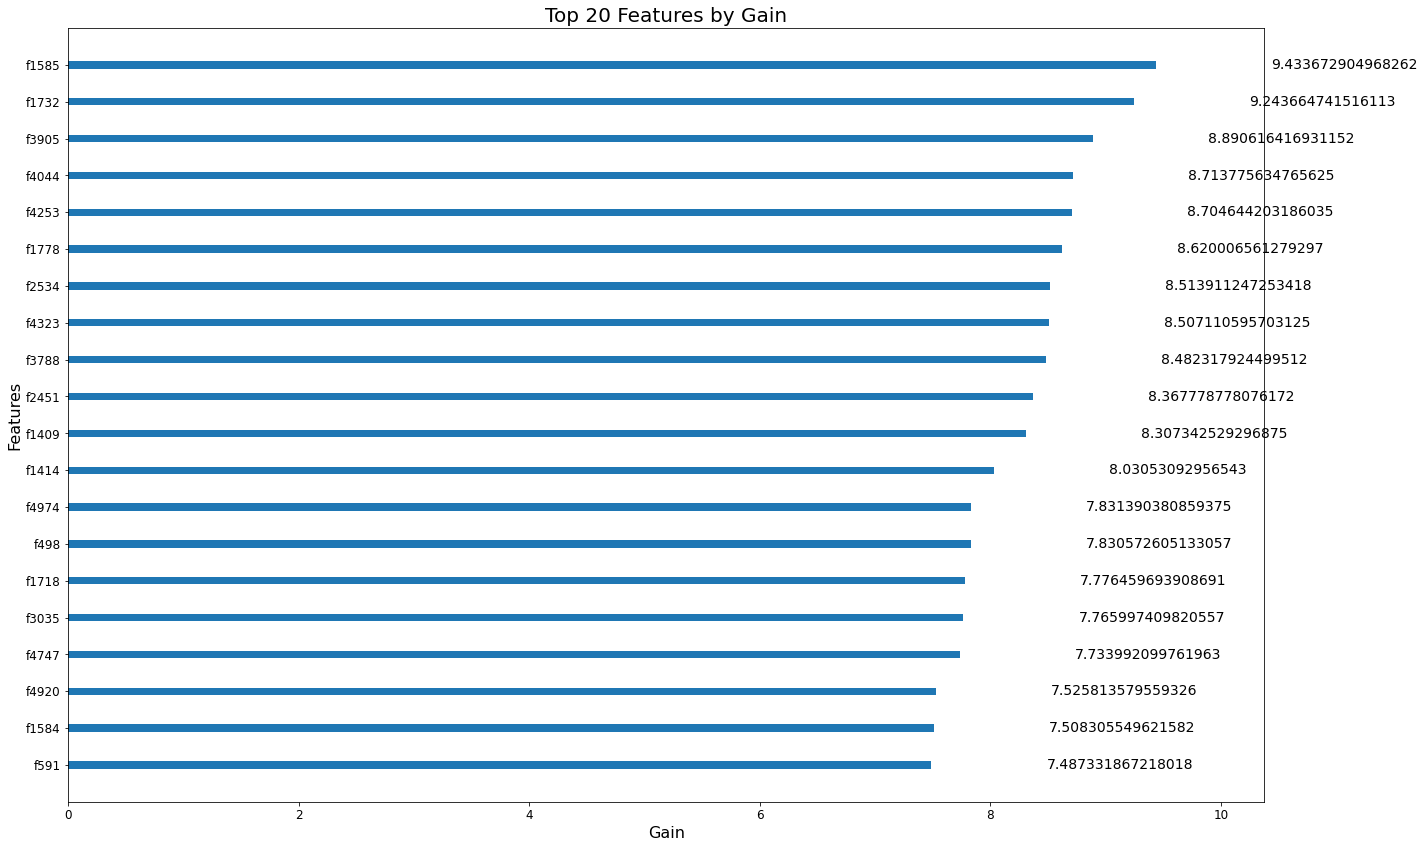

In [10]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot features
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(
    model,
    ax=ax,
    importance_type='gain',
    max_num_features=20,
    title='Top 20 Features by Gain',
    xlabel='Gain',
    grid=False
)
plt.title("Top 20 Features by Gain", fontsize=20)
plt.tight_layout()
plt.show()

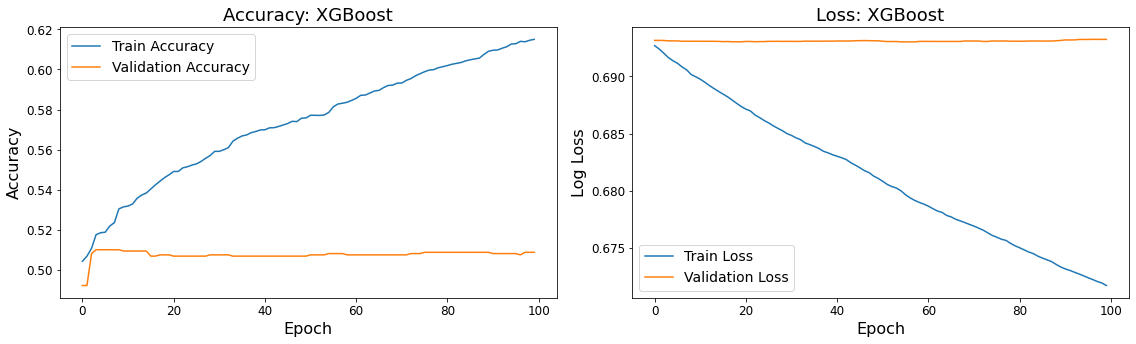

In [11]:
import matplotlib.pyplot as plt

# Pull results from model evals
results = model.evals_result()

train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

if 'error' in results['validation_0']:
    train_error = results['validation_0']['error']
    val_error = results['validation_1']['error']
    train_acc = [1 - e for e in train_error]
    val_acc = [1 - e for e in val_error]
else:
    train_acc = val_acc = None  # No accuracy tracked

# Generate plots
plt.figure(figsize=(16, 5))
if train_acc and val_acc:
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy: XGBoost')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    print("Note: Accuracy not tracked. Set eval_metric=['logloss', 'error'] to include it.")

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss: XGBoost')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

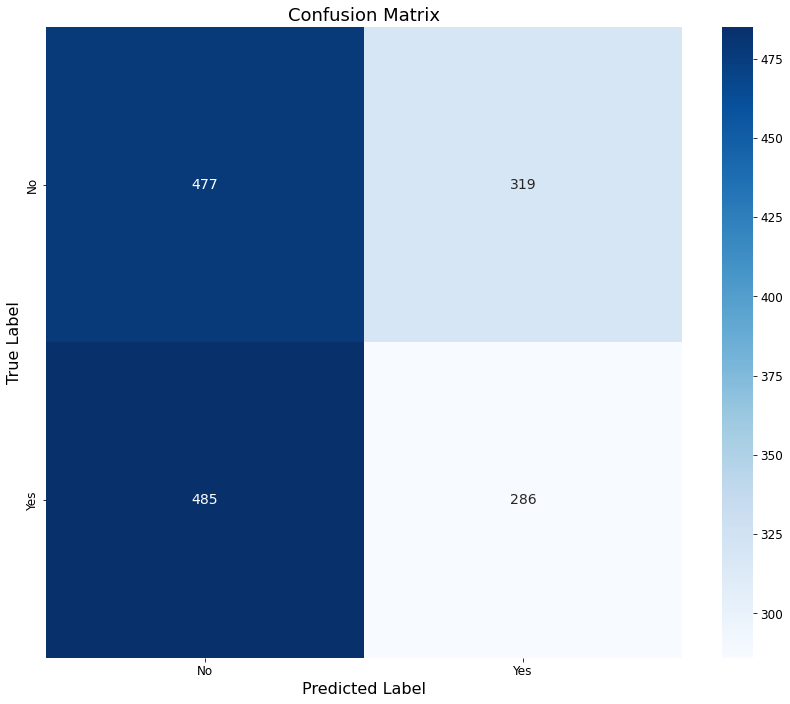

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generat confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Save model build after training
model.save_model("models/xgb_model.json")  # Other model formats .bst or .ubj formats

# Save as a pretrained model
# Example usage:
import xgboost as xgb

# Load pretrained model
model = xgb.XGBClassifier()
model.load_model("xgb_model.json")

# Evaluate or continue training
# model.predict(...)
# model.fit(...) with new data if needed

## cpu-only build

In [ ]:
# XGBoost CPU-only build
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['XGBOOST_FORCE_CPU'] = '1'

import numpy as np
import xgboost as xgb
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
USE_PERCENTAGE = 0.10
train_size = int(USE_PERCENTAGE * len(dataset["train"]))
val_size = int(USE_PERCENTAGE * len(dataset["val"]))
train_data = dataset["train"].select(range(train_size))
val_data = dataset["val"].select(range(val_size))


# Binary labels: 1 = correct LaTeX, 0 = mismatch
latex_pool = train_data["latex"]

def add_label(example):
    if random.random() > 0.5:
        example["target"] = 1
        example["paired_latex"] = example["latex"]
    else:
        wrong = random.choice(latex_pool)
        while wrong == example["latex"]:
            wrong = random.choice(latex_pool)
        example["target"] = 0
        example["paired_latex"] = wrong
    return example

train_data = train_data.map(add_label)
val_data = val_data.map(add_label)


# TF-IDF text encoding
X_train = train_data["paired_latex"]
y_train = np.array(train_data["target"])
X_val = val_data["paired_latex"]
y_val = np.array(val_data["target"])

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


# Train model
model = xgb.XGBClassifier(
    tree_method='hist',
    predictor='cpu_predictor',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric=["logloss", "error"],
    verbosity=1
)

print("Training on CPU only...")
model.fit(
    X_train_vec,
    y_train,
    eval_set=[(X_train_vec, y_train), (X_val_vec, y_val)],
    verbose=False
)


# Model training history
evals_result = model.evals_result()
history = {
    "loss": evals_result["validation_0"]["logloss"],
    "val_loss": evals_result["validation_1"]["logloss"],
    "accuracy": [1 - e for e in evals_result["validation_0"]["error"]],
    "val_accuracy": [1 - e for e in evals_result["validation_1"]["error"]],
}


# Evals
y_pred = model.predict(X_val_vec)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Feature importance plot CPU-only build
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(model, max_num_features=20, importance_type='gain', ax=ax)
plt.title("Top 20 Features by Gain", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Train/Loss plots CPU-only build
plt.figure(figsize=(16, 9))
plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix CPU-only build
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Results are surprising. XGBoost generalizes better when observing resuts from the confusion matrix. Transfer learning was not implemented. Model 4 required a lot of testing and building. Feature engineering in this space is required.

In [ ]:
# end of model 4 build and test runs